# Menu <a class="anchor" id="menu"></a>
   
* [1. Introduction à l'analyse de sentiments](#introduction)
* [2. Analyses Exploratoires des jeux de données](#EDA)
    * [2.1 Vérifications de base](#EDA_basics)
        * [Vérification des `types des colonnes`](#EDA_types)
        * [Vérification des `valeurs manquantes`](#EDA_missing)
        * [Vérification des `doublons`](#EDA_duplicates)
    * [2.2 Analyse de la colonne `target`](#EDA_target)
    * [2.3 Analyse de la colonne `ids`](#EDA_ids)
    * [2.4 Analyse de la colonne `date`](#EDA_date)
    * [2.5 Analyse de la colonne `flag`](#EDA_flag)
    * [2.6 Analyse de la colonne `user`](#EDA_user)
    * [2.7 Analyse de la colonne `text`](#EDA_text)
    * [2.8 Création d'un jeu de données de travail](#EDA_new_dataset)
* [3. Feature engineering *(NOT DONE YET)*](#Feature_Engineering)
* [4. Préparation des textes](#NLP_preprocess)
    * [4.1 Tokenization](#NLP_tokenize)
    * [4.2 Filtrage des tokens](#NLP_filter)
    * [4.3 Lemmatization des tokens](#NLP_lemmatize)
    * [4.4 Suppression des mots les plus fréquents](#NLP_most_frequents)
    * [4.5 Création du Dictionnaire](#NLP_dict)
* [5. Sauvegarde du jeu de données de travail](#save_dataset)

In [1]:
import os
import pathlib
from zipfile import ZipFile
from datetime import datetime
from dateutil import parser

import pandas as pd
import numpy as np

import spacy
import spacy_fastlang
from spacy.tokens import DocBin
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

random_seed = 0
np.random.seed(random_seed)

LOAD_TOKENS_FROM_FILE = True
TOKENS_PATH = pathlib.Path(pathlib.Path().absolute(), 'data', 'tokens.bin')

---
---
# 1. Introduction à l'analyse de sentiment <a class="anchor" id="introduction"></a> [⇪](#menu)

TODO

---
---
# 2. Analyse exploratoire du jeu de données <a class="anchor" id="EDA"></a> [⇪](#menu)

The `sentiment140` dataset contains 1,600,000 tweets extracted using the twitter api.

The tweets have been annotated *(0 = negative, 4 = positive)* and they can be used to detect sentiment.

It contains the following 6 fields:
- `target`: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- `ids`: The id of the tweet ( 2087)
- `date`: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- `flag`: The query (lyx). If there is no query, then this value is NO_QUERY.
- `user`: the user that tweeted (robotickilldozr)
- `text`: the text of the tweet (Lyx is cool)

In [2]:
source = pathlib.Path(pathlib.Path().absolute(), 'data', 'sentiment140.zip')

### Déterminons l'encodage utilisé sur ce jeu de données *(avec [Charset Normalizer](https://pypi.org/project/charset-normalizer/))*

In [3]:
import charset_normalizer
with open(source, 'rb') as rawdata:
    result = charset_normalizer.detect(rawdata.read(1000000))
result

{'encoding': None, 'language': '', 'confidence': None}

>#### Aucun encodage particulier ne ressort; le jeu de données est donc certainement composés de textes encodés de différentes façons...

### Chargeons le jeu de données

In [4]:
# Method 2 (Unzip with pd.read_csv)

df = pd.read_csv(
    source, 
    compression='zip', 
    encoding='ISO-8859-1',
    #encoding='utf-8', 
    #encoding='cp1252', 
    #encoding = 'latin',
    header=None, 
    names=['target', 'ids', 'date', 'flag', 'user', 'text'],
    #parse_dates=['date'],
    #infer_datetime_format=True,
    #date_parser=parse_tweet_dates,
)

In [5]:
display(df.head(2), df.shape)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1600000, 6)

---
## 2.1 Vérifications de base  <a class="anchor" id="EDA_basics"></a> [⇪](#menu)

### Vérifions les `types des colonnes` <a class="anchor" id="EDA_types"></a> [⇪](#menu)

In [6]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


#### Ajustons les types de colonnes d'après les informations dont nous disposons

> https://www.kaggle.com/code/abdeljalilouedraogo/twitter-sentiment-analysis-on-sentiment140-dataset/data
> - `target`: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
> - `ids`: The id of the tweet ( 2087)
> - `date`: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
> - `flag`: The query (lyx). If there is no query, then this value is NO_QUERY.
> - `user`: the user that tweeted (robotickilldozr)
> - `text`: the text of the tweet (Lyx is cool)


In [7]:
df = df.astype({
    "target": 'category', 
    "ids": 'category',
    # "date": 'datetime64',
    "flag": 'category',
    "user": 'category',
    # "text": 'object',
})

>#### Nous aurions pu mettre les dates dans un format adapté, mais la time zone PDT pose problème, on va donc s'en occuper un peu plus loin dans une section dédiée

In [8]:
df.dtypes

target    category
ids       category
date        object
flag      category
user      category
text        object
dtype: object

In [9]:
df.head(2)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


### Cherchons les éventuels `valeurs manquantes` <a class="anchor" id="EDA_missing"></a> [⇪](#menu)

In [10]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

>#### Nous n'avons aucune valeur manquante

### Cherchons les éventuels `doublons` <a class="anchor" id="EDA_duplicates"></a> [⇪](#menu)

#### Vérifions sur l'ensemble des colonnes

In [11]:
df.duplicated().sum()

0

#### Vérifions sans tenir compte de la `target` au cas ou certains doublons auraient les deux valeurs

In [12]:
subset = ['ids', 'date', 'flag', 'user', 'text']
df.duplicated(subset=subset).sum()

1685

In [13]:
df[df.duplicated(keep=False, subset=subset)].sort_values('text').head(10)

,target,ids,date,flag,user,text
1394129,4,2053581479,Sat Jun 06 05:02:55 PDT 2009,NO_QUERY,FunStarLiz,British weather is back i see! Oh well Birtne...
385331,0,2053581479,Sat Jun 06 05:02:55 PDT 2009,NO_QUERY,FunStarLiz,British weather is back i see! Oh well Birtne...
1077756,4,1967735038,Fri May 29 20:07:06 PDT 2009,NO_QUERY,macpoulet67,Raining tomorrow afternoon but its going to b...
184535,0,1967735038,Fri May 29 20:07:06 PDT 2009,NO_QUERY,macpoulet67,Raining tomorrow afternoon but its going to b...
118605,0,1827871029,Sun May 17 11:37:14 PDT 2009,NO_QUERY,mckyliecooper,Uhm.. science! -.- Verrrry boring and LONG G...
968532,4,1827871029,Sun May 17 11:37:14 PDT 2009,NO_QUERY,mckyliecooper,Uhm.. science! -.- Verrrry boring and LONG G...
1443107,4,2062079422,Sat Jun 06 22:17:07 PDT 2009,NO_QUERY,kiarapop,back to maths. i wish i could stab it. but at...
419860,0,2062079422,Sat Jun 06 22:17:07 PDT 2009,NO_QUERY,kiarapop,back to maths. i wish i could stab it. but at...
190549,0,1969383342,Fri May 29 23:51:54 PDT 2009,NO_QUERY,iSelah,but then again
1086997,4,1969383342,Fri May 29 23:51:54 PDT 2009,NO_QUERY,iSelah,but then again


>#### On constate que l'on a 1685 échantillons pour lesquels on a à la fois une target *positive* (4) et une target *negative* (0)...
> comme on ne connait pas la véritable target des ces échantillons en double, il nous faut supprimer les 3370 *(2 x 1685)*

In [14]:
df.drop_duplicates(keep=False, subset=subset, inplace=True)

In [15]:
df.duplicated(subset=subset).sum()

0

In [16]:
display(df.head(2), df.shape)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1596630, 6)

#### Vérifions si l'on a des `textes` qui apparaissent plusieurs fois avec la même `target`

In [17]:
subset= ['text']
df.duplicated(subset=subset).sum()

16836

In [18]:
df[df.duplicated(keep=False, subset=subset)].sort_values('text').head(10)

,target,ids,date,flag,user,text
271505,0,1990029536,Mon Jun 01 03:38:42 PDT 2009,NO_QUERY,Jana1503,David must be hospitalized for five days end...
271472,0,1990023076,Mon Jun 01 03:37:19 PDT 2009,NO_QUERY,Jana1503,David must be hospitalized for five days end...
1132074,4,1975956536,Sat May 30 16:16:11 PDT 2009,NO_QUERY,dstocum,bathroom is clean..... now on to more enjoya...
1132076,4,1975956610,Sat May 30 16:16:11 PDT 2009,NO_QUERY,DavidStocum,bathroom is clean..... now on to more enjoya...
540173,0,2199659424,Tue Jun 16 17:49:15 PDT 2009,NO_QUERY,cutthroatpixie,#IMISSCATH #IMISSCATH #IMISSCATH #IMISSCATH #...
540159,0,2199656747,Tue Jun 16 17:49:00 PDT 2009,NO_QUERY,cutthroatpixie,#IMISSCATH #IMISSCATH #IMISSCATH #IMISSCATH #...
1364947,4,2049859280,Fri Jun 05 17:37:43 PDT 2009,NO_QUERY,MonicaEira,#seb-day #seb-day #seb-day #seb-day #seb-day ...
1357123,4,2047924312,Fri Jun 05 14:23:16 PDT 2009,NO_QUERY,DihDesrosiers,#seb-day #seb-day #seb-day #seb-day #seb-day ...
331063,0,2012536119,Tue Jun 02 20:49:46 PDT 2009,NO_QUERY,iShatara,*tear*
287201,0,1994140773,Mon Jun 01 11:28:38 PDT 2009,NO_QUERY,vanitiiluv,*tear*


>#### On constate que l'on a encore 16836 échantillons dont les textes apparaissent plusieurs fois dans le jeu de données
> il convient donc de n'en garder qu'un seul exemplaire de chaque

In [19]:
df.drop_duplicates(keep='first', subset=subset, inplace=True)

In [20]:
df.duplicated(subset=subset).sum()

0

In [21]:
display(df.head(2), df.shape)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 6)

In [22]:
df.text.describe()

count                                               1579794
unique                                              1579794
top       @switchfoot http://twitpic.com/2y1zl - Awww, t...
freq                                                      1
Name: text, dtype: object

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer les doublons qui ont le même texte et des targets différentes.<br><u>*(action: faite juste au dessus)*</u>
> - ✅ Supprimer les doublons qui ont le même texte et la même target.<br><u>*(action: faite juste au dessus)*</u>

---
## 2.2 Analyse de la colonne `target` <a class="anchor" id="EDA_target"></a> [⇪](#menu)

In [23]:
df.target.value_counts()

4    791281
0    788513
Name: target, dtype: int64

>#### On constate donc que les targets sont équitablement distribuées entre 0 *(negative)* et 4 *(positive)*, mais qu'il n'y a pas de 2 *(neutral)*
> il n'est donc pas nécessaire d'effectuer un ré-équilibrage, mais nous pourrions changer la colonne en bool ou rendre les labels plus facile à identifier.

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Renommer les targets pour éviter les confusions.<br><u>*(action: faite juste en dessous)*</u>

In [24]:
# remap = {0: "negative", 4: "positive"}
remap = {0: 0, 4: 1}
df.replace({"target": remap}, inplace=True)

In [25]:
df.target.value_counts()

1    791281
0    788513
Name: target, dtype: int64

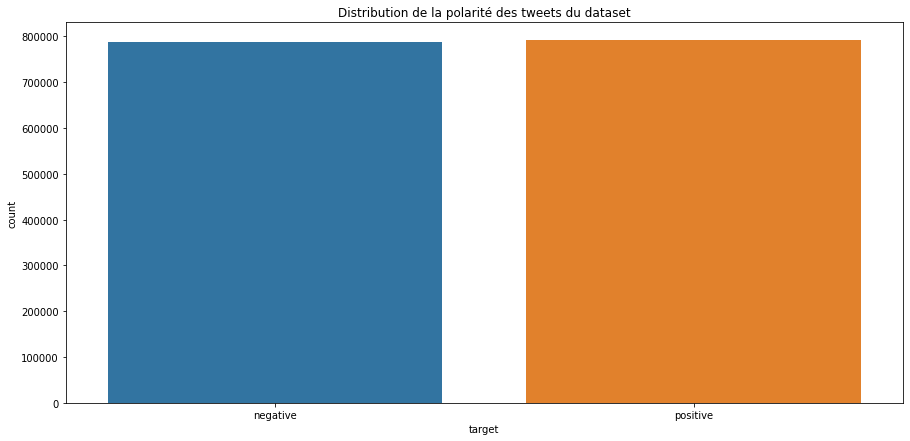

In [26]:
fig = plt.figure(figsize=(15, 7))
sns.barplot(data=df.target.replace({0:"negative", 1:"positive"}).value_counts().reset_index().rename(columns={'target':'count', 'index':'target'}), x='target', y='count')
plt.title("Distribution de la polarité des tweets du dataset")
plt.show()

---
## 2.3 Analyse de la colonne `ids` <a class="anchor" id="EDA_ids"></a> [⇪](#menu)

In [27]:
df.ids.duplicated().sum()

0

In [28]:
df.ids.describe()

count        1579794
unique       1579794
top       1467810369
freq               1
Name: ids, dtype: int64

>#### Chaque `ids` est unique et n'apporte donc aucune plus-value à notre jeu de données

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `ids` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [29]:
df.drop(columns=['ids'], inplace=True)

In [30]:
display(df.head(2), df.shape)

,target,date,flag,user,text
0,0,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 5)

---
## 2.4 Analyse de la colonne `date` <a class="anchor" id="EDA_date"></a> [⇪](#menu)

In [31]:
def parse_tweet_dates(date_time_str):
    return parser.parse(date_time_str,  tzinfos={"PDT": -7*3600})

In [32]:
df['date'] = df.date.apply(parse_tweet_dates)

In [33]:
display(df.head(2), df.shape)

,target,date,flag,user,text
0,0,2009-04-06 22:19:45-07:00,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,2009-04-06 22:19:49-07:00,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 5)

### Regardons les limites de la periode de publication des tweets de notre dataset

In [34]:
df.date.describe(datetime_is_numeric=True)

count                                1579794
mean     2009-05-31 06:53:34.174260992-07:00
min                2009-04-06 22:19:45-07:00
25%                2009-05-28 22:53:24-07:00
50%                2009-06-02 02:56:40-07:00
75%                2009-06-15 05:14:33-07:00
max                2009-06-25 10:28:31-07:00
Name: date, dtype: object

>#### On a donc des tweets dont les dates s'étalent du 06/04/2009 au 25/06/2009
> Il n'y a pas de raison que le lexique utilisé pour qualifier ce qui est *positif* ou *négatif* change en si peu de temps, donc on peut conserver l'ensemble de l'intervalle

### Regardons à présent la distribution des tweet dans le temps

In [35]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, show_percent=False, x_label=None, y_label=None, **args):
    
    if show_percent:
        total = data_.values.sum()
        data_ = round(data_/total*100.0,2)
        
    fig = plt.figure(figsize=(15, 4))
        
    #with plt.rc_context({
    #    'axes.edgecolor':'orange',
    #    'xtick.color':'orange', 
    #    'ytick.color':'orange', 
    #    'text.color': 'orange',
    #    'axes.labelcolor': 'orange',
        #'figure.facecolor':'orange'
    #}):

    ax = sns.barplot(data=data_, **args)

    if show_values:
        ax.bar_label(ax.containers[0])

    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

    #fig.savefig(f"medias/export.png", transparent=True)

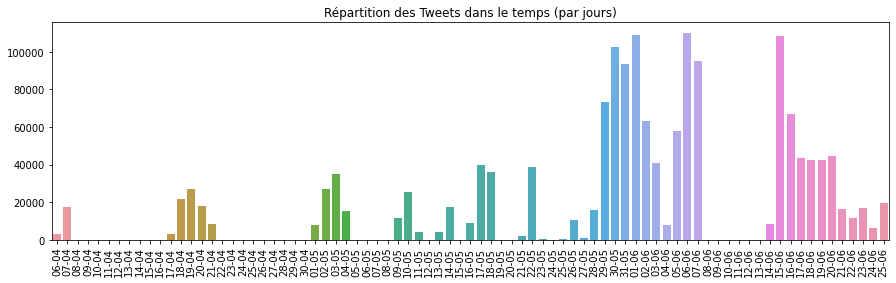

In [36]:
select = df[['date']].copy()
select['short_date'] = select.date.apply(lambda x: x.strftime("%Y-%m-%d"))
#selection['short_date'] = selection.date.apply(lambda x: datetime.strptime(x[4:10] + x[-5:], "%b %d %Y").strftime("%m %d %Y"))
select = pd.DataFrame(select.groupby('short_date').size(), columns=['count'])# .sort_values('short_date')

# add missing dates
idx = pd.date_range('2009-04-06', '2009-06-25')
select.reset_index(inplace=True)
select.index = pd.DatetimeIndex(select['short_date'])
select = select.reindex(idx, fill_value=0)
select = select.drop(columns=['short_date'])
select.index = select.index.strftime('%d-%m')
    
plot_bars(select.T, "Répartition des Tweets dans le temps (par jours)", labels_modulo=1, show_values=False)

>#### On constate que tweets sont inégalement répartis sur notre intervalle de temps
> mais c'est à priori sans conséquence *(selon notre compréhension du jeu de données **à ce stade**)*

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `date` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [37]:
df.drop(columns=['date'], inplace=True)

In [38]:
display(df.head(2), df.shape)

,target,flag,user,text
0,0,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 4)

---
## 2.5 Analyse de la colonne `flag` <a class="anchor" id="EDA_flag"></a> [⇪](#menu)

In [39]:
df.flag.value_counts(dropna=False)

NO_QUERY    1579794
Name: flag, dtype: int64

>#### Il n'y a qu'une seule valeur dans cette colonne, elle ne présente donc aucun intérêt et peut être retirée.

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `flag` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [40]:
df.drop(columns=['flag'], inplace=True)

In [41]:
display(df.head(2), df.shape)

,target,user,text
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 3)

---
## 2.6 Analyse de la colonne `user` <a class="anchor" id="EDA_user"></a> [⇪](#menu)

In [42]:
df.user.describe()

count      1579794
unique      653858
top       lost_dog
freq           549
Name: user, dtype: object

>#### On a une répartition inégale du nombre de Tweets par utilisateurs
> mais c'est à priori sans conséquence *(selon notre compréhension du jeu de données **à ce stade**)*

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `user` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [43]:
df.drop(columns=['user'], inplace=True)

In [44]:
display(df.head(2), df.shape)

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...


(1579794, 2)

---
## 2.7 Analyse de la colonne `text` <a class="anchor" id="EDA_text"></a> [⇪](#menu)

In [45]:
df.duplicated(subset=['text']).sum()

0

### Visualisons le jeu de données avant la tokenisation

In [46]:
from wordcloud import WordCloud

In [47]:
from PIL import Image

In [48]:
def plot_wordcloud(text, from_frequency=False, name="wordcloud"):
    mask = np.array(Image.open("medias/twitter.jpg"))
    
    # Create the wordcloud object (the size depends on the mask...)
    wordcloud_export = WordCloud(background_color=None, mode="RGBA", width=1000, height=700, margin=2, collocations=False, random_state=random_seed, mask=mask)
    wordcloud_clean = WordCloud(background_color="White", mode="RGB", width=1000, height=700, margin=2, collocations=False, random_state=random_seed, mask=mask)
    
    if from_frequency:
        wordcloud_export = wordcloud_export.generate_from_frequencies(text)
        wordcloud_clean = wordcloud_clean.generate_from_frequencies(text)
    else:
        wordcloud_export = wordcloud_export.generate(text)
        wordcloud_clean = wordcloud_clean.generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(15, 10.5))
    plt.imshow(wordcloud_clean, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
    
    # Export
    wordcloud_export.to_file(f"medias/{name}.png")
    
    #fig.savefig(f"medias/{name}.png", transparent=True)

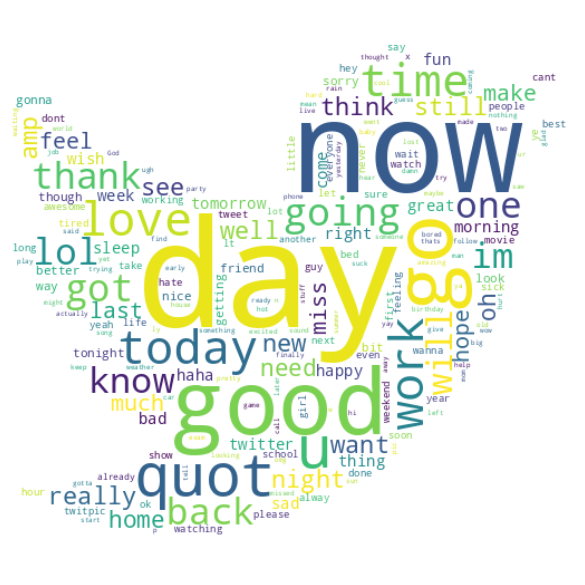

In [49]:
plot_wordcloud(" ".join([x for x in df.text]), name="wordcloud1")

### Étudions la répartition de la taille des tweets *(en nombre de mots et en nombre de caractères)*

In [50]:
def plot_tweet_sizes(data, col_name, x_label, y_label, title1, title2):
    select = pd.DataFrame(data[col_name].value_counts()).reset_index()
    select.sort_values(by='index', inplace=True)
    select.set_index('index', inplace=True)

    size_mean = data[col_name].mean()
    size_median = data[col_name].median()
    max_count = np.array(select).max()

    fig = plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    sns.lineplot(data=select, y=col_name, x='index')
    plt.plot([size_mean, size_mean],[0,max_count], label=f"Moyenne ({size_mean:.2f})", alpha=0.5)
    plt.plot([size_median, size_median],[0,max_count], label=f"Médiane ({size_median:.2f})", alpha=0.5)
    plt.title(title1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    #plt.ylim(0,10000)
    plt.legend()

    select2 = np.cumsum(select)

    plt.subplot(1,2,2)
    sns.lineplot(data=select2, y=col_name, x='index')
    plt.title(title2)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

#### Répartition par nombre de mots

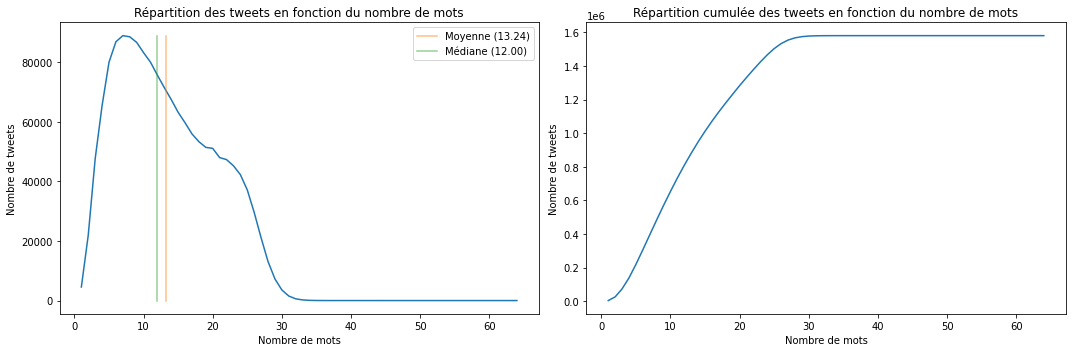

In [51]:
data_clean = df.copy()
data_clean['tweet_words'] = data_clean.text.apply(lambda x: len(x.split()))
plot_tweet_sizes(
    data_clean, 
    col_name = 'tweet_words', 
    title1 = "Répartition des tweets en fonction du nombre de mots",
    title2 = "Répartition cumulée des tweets en fonction du nombre de mots",
    x_label = "Nombre de mots",
    y_label = "Nombre de tweets",
)

#### Répartition par nombre de caractères

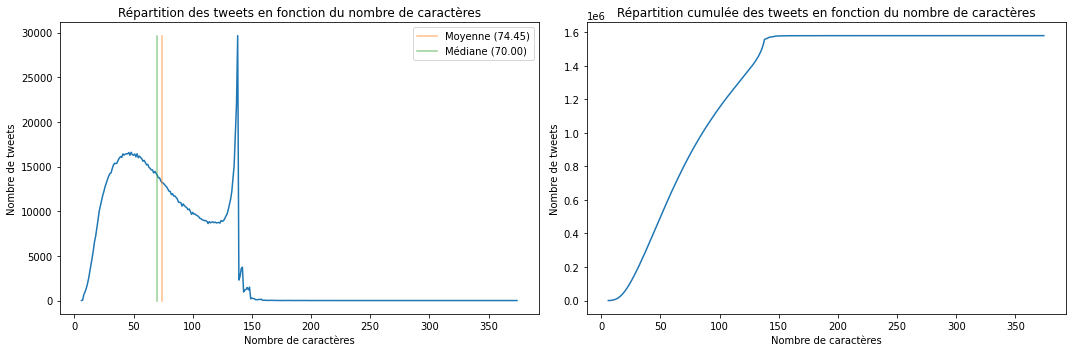

In [52]:
data_clean['tweet_chars'] = data_clean.text.apply(lambda x: len(x))
plot_tweet_sizes(
    data_clean, 
    col_name = 'tweet_chars', 
    title1 = "Répartition des tweets en fonction du nombre de caractères",
    title2 = "Répartition cumulée des tweets en fonction du nombre de caractères",
    x_label = "Nombre de caractères",
    y_label = "Nombre de tweets",
)

In [53]:
data_clean[['tweet_chars', 'tweet_words']].describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_chars,1579794.0,74.452939,36.206900,6.0,44.0,70.0,104.0,374.0
tweet_words,1579794.0,13.241761,6.924276,1.0,7.0,12.0,19.0,64.0


In [54]:
(data_clean.tweet_chars > 140).sum()

17009

>#### Il se pourrait que l'on ait des outliers à traiter.
> En effet, en 2009 *(année que nous avons identifié dans la colonne date)* la limite de caractères des tweets était de 140 or on constate que 17009 dépassent cette limite

### Essayons de comprendre si les échantillons qui dépassent la limite de 140 sont des outliers ou pas

In [55]:
outliers = data_clean[(data_clean.tweet_chars > 140)].sort_values('tweet_chars', ascending=False).head()
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

@catfish_ohm à¹à¸à¹à¸²à¹à¸«à¹à¸?à¸²à¸£à¹à¸à¸¹à¸à¸?à¸¸à¹à¸£à¸°(à¸ªà¸±à¸ªà¹+à¸¢à¸¹à¸£à¸´à¹?à¸?à¹à¸à¹à¹?à¸à¸à¸à¸°à¸à¸­à¸à¸µà¸¡à¸´à¹à¸?à¸°à¸«à¸§à¸(à¸à¸à¸²à¸à¹à¸à¸´à¸à¹?à¸?à¸¢à¸±à¸à¹à¸à¸¢à¹à¸«à¹à¹à¸¡à¹à¹à¸à¹à¹à¸«à¸£à¸­.à¹?à¸à¹à¸à¹à¸²à¸à¹à¸«à¸­à¸°à¸£à¸²à¸¢à¸à¸±à¹à¸à¹à¸à¸²à¹à¸¡à¹à¸­à¸°à¸?à¸§à¹à¸²à¸à¸¥à¸²à¹?à¸¡à¸§à¹à¸¢à¸­à¸° =  374

@iannnnn à¹à¸à¸µà¹à¸¢à¸§à¸­à¸µà¸?à¸à¸±à¸?à¸à¸£à¸¹à¹à¸à¸à¹à¸£à¸µà¸¢à¸?à¸à¸µà¸¡ Graphic à¹à¸à¹à¸²à¸¡à¸²à¹?à¸¥à¹à¸§à¸à¸£à¸±à¸à¹à¸¥à¹à¸?à¸à¹à¸­à¸¢à¹à¸«à¹à¸¡à¸±à¸à¸à¸¥à¹à¸²à¸¢à¸?à¸±à¸à¸¢à¸´à¹à¸à¸à¸¶à¹à¸à¸à¸£à¸±à¸ à¹à¸à¸£à¸²à¸°à¸«à¸²à¸?à¹à¸­à¸²à¸¡à¸²à¹à¸à¸µà¸¢à¸à¸?à¸±à¸à¸à¸à¸¡à¸µà¸à¸±à¸?à¸«à¸²à¸­à¸¢à¹à¸²à¸à¸§à¹à¸²à¸à¸£à¸±à¸.  369

5 days till new top gear  î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?

In [56]:
outliers = data_clean[(data_clean.tweet_chars > 140)].sort_values('tweet_chars', ascending=True).head()
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers  141

@tickedypoph my ex BF a virgo &amp; SO particular! but clever - so i know you'll think up some gold. have a great swim! it's 11 degrees here  141

@pocketedward vocÃª compreende inglÃªs ? que mara ! how much is any twilight doll ? donÂ´t have in brasil  xoxo , uma pessoa brasileira HAHA! 141

@ihackinjosh beejive &amp; 2 more app will be out with their push versions soon. But all of them mention that we will need MobileMe account.  141

i hate how i want to type more than the allowed amount of words, finding myself trying to shorten my words to bad punctuation &amp; spelling  141



>#### On constate que d'étranges séquences ce caractères apparaissent dans les tweets qui dépassent la limite de 140.
> - pourtant le jeu de données utilisé stipule que c'est un jeu de données **sans emoticons**.
> - il se pourrait que ce soit des tweets rédigés dans une autre langues ; **caractères syllabiques**
> - il se pourrait que ce soit des textes encodés dans **d'autres encodages** que celui que nous avons utilisé
> - ou encore des **codes html**

### Convertisons les caractères écrits avec des entitées html *(&amp, &quote, etc.)*

In [57]:
import html

In [58]:
data_clean['text'] = data_clean.text.apply(lambda x : html.unescape(x))

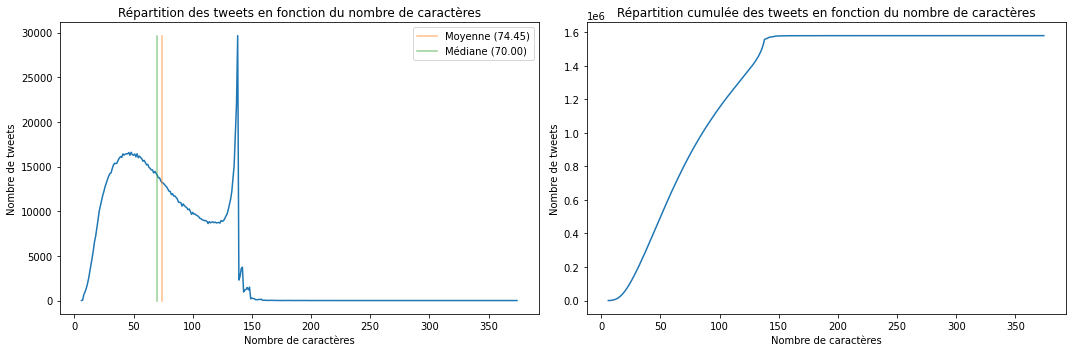

In [59]:
# data_clean = df.copy()
data_clean['tweet_chars'] = df.text.apply(lambda x: len(x))
plot_tweet_sizes(
    data_clean, 
    col_name = 'tweet_chars', 
    title1 = "Répartition des tweets en fonction du nombre de caractères",
    title2 = "Répartition cumulée des tweets en fonction du nombre de caractères",
    x_label = "Nombre de caractères",
    y_label = "Nombre de tweets",
)

In [60]:
(data_clean.tweet_chars > 140).sum()

17009

>#### On constate qu'après le traitement des balises HTML il ne reste plus que 685 textes dépassant 140 caractères *(contre 17009 avant)*

In [61]:
outliers = data_clean[(data_clean.tweet_chars > 140)].sort_values('tweet_chars', ascending=False).head(5)
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

@catfish_ohm à¹à¸à¹à¸²à¹à¸«à¹à¸?à¸²à¸£à¹à¸à¸¹à¸à¸?à¸¸à¹à¸£à¸°(à¸ªà¸±à¸ªà¹+à¸¢à¸¹à¸£à¸´à¹?à¸?à¹à¸à¹à¹?à¸à¸à¸à¸°à¸à¸­à¸à¸µà¸¡à¸´à¹à¸?à¸°à¸«à¸§à¸(à¸à¸à¸²à¸à¹à¸à¸´à¸à¹?à¸?à¸¢à¸±à¸à¹à¸à¸¢à¹à¸«à¹à¹à¸¡à¹à¹à¸à¹à¹à¸«à¸£à¸­.à¹?à¸à¹à¸à¹à¸²à¸à¹à¸«à¸­à¸°à¸£à¸²à¸¢à¸à¸±à¹à¸à¹à¸à¸²à¹à¸¡à¹à¸­à¸°à¸?à¸§à¹à¸²à¸à¸¥à¸²à¹?à¸¡à¸§à¹à¸¢à¸­à¸° =  374

@iannnnn à¹à¸à¸µà¹à¸¢à¸§à¸­à¸µà¸?à¸à¸±à¸?à¸à¸£à¸¹à¹à¸à¸à¹à¸£à¸µà¸¢à¸?à¸à¸µà¸¡ Graphic à¹à¸à¹à¸²à¸¡à¸²à¹?à¸¥à¹à¸§à¸à¸£à¸±à¸à¹à¸¥à¹à¸?à¸à¹à¸­à¸¢à¹à¸«à¹à¸¡à¸±à¸à¸à¸¥à¹à¸²à¸¢à¸?à¸±à¸à¸¢à¸´à¹à¸à¸à¸¶à¹à¸à¸à¸£à¸±à¸ à¹à¸à¸£à¸²à¸°à¸«à¸²à¸?à¹à¸­à¸²à¸¡à¸²à¹à¸à¸µà¸¢à¸à¸?à¸±à¸à¸à¸à¸¡à¸µà¸à¸±à¸?à¸«à¸²à¸­à¸¢à¹à¸²à¸à¸§à¹à¸²à¸à¸£à¸±à¸.  369

5 days till new top gear  î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?

In [62]:
outliers = data_clean[(data_clean.tweet_chars > 140)].sort_values('tweet_chars', ascending=True).head(5)
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers  141

@tickedypoph my ex BF a virgo & SO particular! but clever - so i know you'll think up some gold. have a great swim! it's 11 degrees here  141

@pocketedward vocÃª compreende inglÃªs ? que mara ! how much is any twilight doll ? donÂ´t have in brasil  xoxo , uma pessoa brasileira HAHA! 141

@ihackinjosh beejive & 2 more app will be out with their push versions soon. But all of them mention that we will need MobileMe account.  141

i hate how i want to type more than the allowed amount of words, finding myself trying to shorten my words to bad punctuation & spelling  141



>#### Malgré le décodage des entitées HTML
> on constate la présence d'encodage UTF-8 non convertis : e.g. Ã© qui devrait être la lettre "é"


### Essayons de récupèrer certains caractères mal interprétés par UTF-8

In [63]:
def encode_spe(x):
    try:
        # return x.decode('utf-8')
        # return x.encode('latin1').decode('utf-8')
        # return x.encode('cp1252').decode('utf-8')
        return x.encode('ISO-8859-1').decode('utf-8')
    except Exception:
        return x
    
df['text'] = df.text.apply(encode_spe)

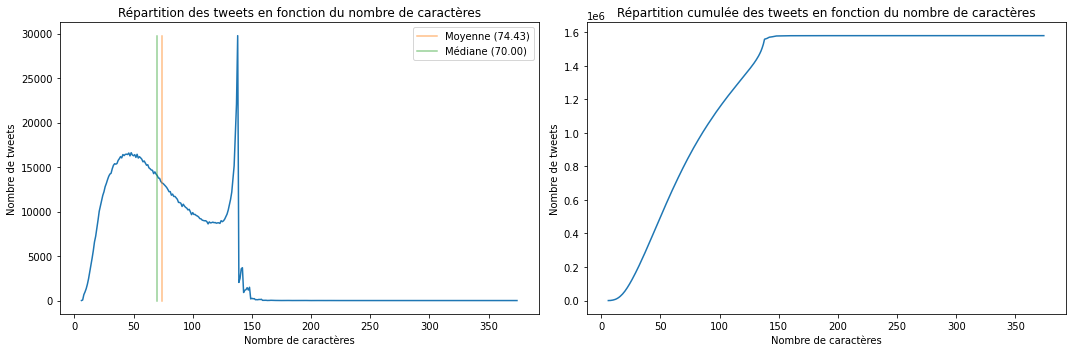

In [64]:
data_clean['tweet_chars'] = df.text.apply(lambda x: len(x))
plot_tweet_sizes(
    data_clean, 
    col_name = 'tweet_chars', 
    title1 = "Répartition des tweets en fonction du nombre de caractères",
    title2 = "Répartition cumulée des tweets en fonction du nombre de caractères",
    x_label = "Nombre de caractères",
    y_label = "Nombre de tweets",
)

In [65]:
(data_clean.tweet_chars > 140).sum()

16686

>#### On constate qu'après le traitement de l'encodage et du HTML il ne reste plus que 391 textes dépassant 140 caractères *(contre 17009 avant)*

In [66]:
outliers = data_clean[(data_clean.tweet_chars > 140)].sort_values('tweet_chars', ascending=False).head(5)
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

@catfish_ohm à¹à¸à¹à¸²à¹à¸«à¹à¸?à¸²à¸£à¹à¸à¸¹à¸à¸?à¸¸à¹à¸£à¸°(à¸ªà¸±à¸ªà¹+à¸¢à¸¹à¸£à¸´à¹?à¸?à¹à¸à¹à¹?à¸à¸à¸à¸°à¸à¸­à¸à¸µà¸¡à¸´à¹à¸?à¸°à¸«à¸§à¸(à¸à¸à¸²à¸à¹à¸à¸´à¸à¹?à¸?à¸¢à¸±à¸à¹à¸à¸¢à¹à¸«à¹à¹à¸¡à¹à¹à¸à¹à¹à¸«à¸£à¸­.à¹?à¸à¹à¸à¹à¸²à¸à¹à¸«à¸­à¸°à¸£à¸²à¸¢à¸à¸±à¹à¸à¹à¸à¸²à¹à¸¡à¹à¸­à¸°à¸?à¸§à¹à¸²à¸à¸¥à¸²à¹?à¸¡à¸§à¹à¸¢à¸­à¸° =  374

@iannnnn à¹à¸à¸µà¹à¸¢à¸§à¸­à¸µà¸?à¸à¸±à¸?à¸à¸£à¸¹à¹à¸à¸à¹à¸£à¸µà¸¢à¸?à¸à¸µà¸¡ Graphic à¹à¸à¹à¸²à¸¡à¸²à¹?à¸¥à¹à¸§à¸à¸£à¸±à¸à¹à¸¥à¹à¸?à¸à¹à¸­à¸¢à¹à¸«à¹à¸¡à¸±à¸à¸à¸¥à¹à¸²à¸¢à¸?à¸±à¸à¸¢à¸´à¹à¸à¸à¸¶à¹à¸à¸à¸£à¸±à¸ à¹à¸à¸£à¸²à¸°à¸«à¸²à¸?à¹à¸­à¸²à¸¡à¸²à¹à¸à¸µà¸¢à¸à¸?à¸±à¸à¸à¸à¸¡à¸µà¸à¸±à¸?à¸«à¸²à¸­à¸¢à¹à¸²à¸à¸§à¹à¸²à¸à¸£à¸±à¸.  369

@neospace à¹à¸£à¸·à¹à¸­à¸à¸à¸±à¹à¸à¸à¸£à¸£à¸à¹à¸à¸£à¸² à¹à¸«à¹à¸à¸à¹à¸§à¸¢à¸à¸µà¹à¹à¸¡à¹à¸à¹à¸­à¸à¹à¸à¸à¸±à¹à¸à¹à¹à¸¥à¹à¸à¸?à¸²à¸£à¹à¸¡à¸·à¸­à¸ "à¸à¹à¸²à¸à¸à¸à¸" à¸?à¸±à¸à¸­à¸µà¸? à¹?à¸à¹à¸à¸µà¹à¸¡à¸²à

In [67]:
outliers = data_clean[(data_clean.tweet_chars > 140)].sort_values('tweet_chars', ascending=True).head(5)
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

@stum450n Hi. Thanks for the follow. Nice website... check your carriage returns though, the bottom of 'Website & brand identity' is out  141

@studio_gal @BebeZed Gurlfrendzz!! Hugs & a bum slap 2 u both! Forget Food Friday. Sending u a bottle of Merlot for the 3 of us to share  141

@emmy_563 Hey I'm fine thanks   and my day is wonderful  <3 I hope you have fun at school of arts right now... ?  Thx for the photo again! 141

There are better & safer things to do in Bangkok than autoerotic asphyxiation.  Falling down for a nap soon. Up late last night worrying. 141

> @totalfilm: Try again...Lunchtime Reading: The Story of Gladiator 2 (http://bit.ly/ROqBZ) If this is 4 real it would be gr8 and mental!  141



>#### Malgré le décodage des entitées HTML et la tentative de correction du décodage UTF-8
> - on constate qu'il reste de nombreux caractères mal convertis.
> - il est fort probable que ce soit des **caractères sylabique** (Russe, Japonais, Chinois, Thaï, Coréen, ...) encodés avec des jeux de caractères que nous n'avons pas utilisé ici.
>
>#### Chercher l'encodage de cette infime fraction de textes problèmatique prendrait trop de temps, il est donc préférable de les supprimer.

---
>#### `TODO`  done ✅ | todo ❌ |
> - ❌ Faut-il supprimer les tweets de 1 mot <br><u>*(action: aucune, finalement je vais les garder pour le moment)*</u>
> - ✅ Faut-il supprimer les outliers *(plus de 140 caractères)*
<br><u>*(action: fait ci-dessous)*</u>

In [68]:
data_clean.shape

(1579794, 4)

In [69]:
data_clean = data_clean[ data_clean.tweet_chars <= 140 ]

In [70]:
data_clean.shape

(1563108, 4)

---
## 2.8 Création d'un jeu de données de travail <a class="anchor" id="EDA_new_dataset"></a> [⇪](#menu)
contenant uniquement les colonnes qui nous intéressent

In [71]:
data_clean = data_clean[['target','text']]

---
---
# 3. Feature engineering *(idée d'amélioration)* <a class="anchor" id="Feature_Engineering"></a> [⇪](#menu)

Au besoin, nous pourrions essayer d'aider nos algorithmes avec de nouvelles features, comme par exemple:
- nombre de mots
- nombre de caractères
- nombre moyens de mots / caractères ?
- nombre de stopwords
- nombre de #hastags
- nombre de @mentions
- nombre de nombres/chiffres
- nombre d'emails
- nombre de majuscules

---
---
# 4. Préparation des textes <a class="anchor" id="NLP_preprocess"></a> [⇪](#menu)

In [72]:
data_nlp = data_clean.sample(500000, random_state=random_seed).copy()

---

## 4.1 Tokenization <a class="anchor" id="NLP_tokenize"></a> [⇪](#menu)
>#### Nous allons profiter de cette étape de tokenisation pour supprimer:
> - les majuscules,
> - les espaces en début et fin de texte.

In [73]:
!python -m spacy download en_core_web_sm -qq
#!python -m spacy download en_core_web_md -qq
nlp = spacy.load('en_core_web_sm')

2022-07-28 01:59:13.019280: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-28 01:59:13.019306: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [74]:
nlp.add_pipe("language_detector")

In [75]:
def tokenize(text):

    # suppression des majuscules
    text = text.lower()

    # suppression des espaces au début et à la fin des textes
    text = text.strip()

    # tokenisation
    return nlp(text)

In [76]:
display(data_nlp.head(2), data_nlp.shape)

,target,text
1180586,1,"OMG YES YES YES, DEGRASSI'S ON AND IM WATCHING..."
1471360,1,@martyndarkly And it's an excuse to get a Wii.


(500000, 2)

### Préparons les Tokens *(ou chargeons les si ils ont déjà été sauvegardés)*

In [77]:
def save_tokens(data, path):
    #doc_bin = DocBin(attrs=["LEMMA", "ENT_IOB", "ENT_TYPE"], store_user_data=True)
    doc_bin = DocBin(store_user_data=True)
    data.apply(lambda x: doc_bin.add(x))
    bytes_data = doc_bin.to_bytes()
    
    with open(path, "wb") as binary_file:
        binary_file.write(bytes_data)
        
def load_tokens(path):
    with open(path, "rb") as binary_file:
        bytes_data = binary_file.read()
        
    nlp = spacy.blank("en")
    doc_bin = DocBin().from_bytes(bytes_data)
    docs = list(doc_bin.get_docs(nlp.vocab))
    
    return docs

In [78]:
if(os.path.exists(TOKENS_PATH) and LOAD_TOKENS_FROM_FILE==True):
    print(f"LOADING Tokens from '{TOKENS_PATH}'")
    data_nlp['tokens'] = load_tokens(TOKENS_PATH)
else:
    print(f"PREPARING Tokens")
    data_nlp['tokens'] = data_nlp.text.apply(tokenize)
    print(f"SAVING Tokens tp '{TOKENS_PATH}'")
    save_tokens(data_nlp['tokens'], TOKENS_PATH)

LOADING Tokens from '/home/valkea/Dev/OpenClassrooms/Projets_AI/P7/data/tokens.bin'


In [79]:
display(data_nlp.head(2), data_nlp.shape)

,target,text,tokens
1180586,1,"OMG YES YES YES, DEGRASSI'S ON AND IM WATCHING...","(omg, yes, yes, yes, ,, degrassi, 's, on, and,..."
1471360,1,@martyndarkly And it's an excuse to get a Wii.,"(@martyndarkly, and, it, 's, an, excuse, to, g..."


(500000, 3)

#### Sauvegardons notre jeu de données à diverses étapes du pre-processing pour pouvoir essayer leur impact sur nos modèles

In [80]:
data_nlp_steps = pd.DataFrame()
data_nlp_steps['tokens_raw'] = data_nlp.text.apply(lambda x: x.split())
# data_nlp_steps['tokens_spacy'] = data_nlp.tokens.apply(lambda x: x.text)
data_nlp_steps['target'] = data_nlp.target
display(data_nlp_steps.head(2), data_nlp_steps.shape)

data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_raw.bin')
joblib.dump((data_nlp_steps), data_nlp_path)

,tokens_raw,target
1180586,"[OMG, YES, YES, YES,, DEGRASSI'S, ON, AND, IM,...",1
1471360,"[@martyndarkly, And, it's, an, excuse, to, get...",1


(500000, 2)

['/home/valkea/Dev/OpenClassrooms/Projets_AI/P7/data/data_nlp_raw.bin']

---
## 4.2 Filtrage des tokens <a class="anchor" id="NLP_filter"></a> [⇪](#menu)

>#### Nous allons profiter de cette étape pour supprimer:
> - ~~les majuscules~~ *(fait lors de la tokenization)*,
> - ~~les espaces en début et fin de texte.~~ *(fait lors de la tokenization)*,
> - tout ce qui n'est pas détecté comme étant de l'anglais *(language & language_score)*,
> - la ponctuation *(PUNCT)*,
> - les stop-words *(is_stop)*,
> - les espaces *(SPACE)*,
> - les chiffres *(is_alpha)*,
> - mais aussi les beaucoup d'autres tags peu utiles dans ce cas *(ADV, AUX, CONJ, CCONJ, DET, PART, PRON, PROPN, SCONJ, SYM)*.
>
>#### Par ailleurs on va utiliser les **lemmes** *(raçines contextualisées)* des mots pour rassembler ceux qui sont assez similaires.

> pos_ tag ist
>
> - `ADJ`: adjective, e.g. big, old, green, incomprehensible, first
> - `ADP`: adposition, e.g. in, to, during
> - `ADV`: adverb, e.g. very, tomorrow, down, where, there
> - `AUX`: auxiliary, e.g. is, has (done), will (do), should (do)
> - `CONJ`: conjunction, e.g. and, or, but
> - `CCONJ`: coordinating conjunction, e.g. and, or, but
> - `DET`: determiner, e.g. a, an, the
> - `INTJ`: interjection, e.g. psst, ouch, bravo, hello
> - `NOUN`: noun, e.g. girl, cat, tree, air, beauty
> - `NUM`: numeral, e.g. 1, 2017, one, seventy-seven, IV, MMXIV
> - `PART`: particle, e.g. ’s, not,
> - `PRON`: pronoun, e.g I, you, he, she, myself, themselves, somebody
> - `PROPN`: proper noun, e.g. Mary, John, London, NATO, HBO
> - `PUNCT`: punctuation, e.g. ., (, ), ?
> - `SCONJ`: subordinating conjunction, e.g. if, while, that
> - `SYM`: symbol, e.g. $, %, §, ©, +, −, ×, ÷, =, :), 😝
> - `VERB`: verb, e.g. run, runs, running, eat, ate, eating
> - `X`: other, e.g. sfpksdpsxmsa
> - `SPACE`: space, e.g. 

In [81]:
def filter_tokens(doc, except_words = []):

    # suppression des majuscules
    # text = text_.lower()

    # suppression des espaces au début et à la fin des textes
    #text = text.strip()

    # tokenisation
    # doc = nlp(text)
    # spacy.displacy.render(doc, style='dep',jupyter=True)
    
    # suppression des stopwords, de la ponctuation, des espaces et des adverbes et de ce qui n'est pas en anglais
    tokens = [token for token in doc 
              if not token.is_stop 
              # and doc._.language == 'en'
              # and doc._.language_score > 0.7
              # and not token.is_punct
              # and not token.is_space 
              # and not token.is_digit 
              and token.is_alpha
              and token.pos_ not in ['ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM'] 
              and token.lemma_ not in except_words
             ]
        
    return tokens if len(tokens) > 1 else "FILTERED"

#### Regardons si il y a des textes dans d'autres langues ou dans de l'anglais approximatif ou argotique

In [82]:
i = 0
for doc in data_nlp.tokens:
    # is in english
    if doc._.language != 'en':
        print("NOT ENGLISH:\n", doc, "\n", "-"*50)
        i += 1
    elif doc._.language_score <= 0.2:
        print(f"GIBBERISH:{doc._.language_score}\n", doc, "\n", "-"*50)
        i += 1
        
    if i == 20:
        break

NOT ENGLISH:
 welcome @operarepetiteur 
 --------------------------------------------------
GIBBERISH:0.19928157329559326
 @raiscaraavalon welcome to ham-a-lot 
 --------------------------------------------------
NOT ENGLISH:
 @justant1 not now sis im out of it  imma drag u when i get to atlanta tho :letsgo: 
 --------------------------------------------------
NOT ENGLISH:
 @arunbasillal ya dat will b cool 
 --------------------------------------------------
GIBBERISH:0.19067050516605377
 http://twitpic.com/3no8d - sweet ass rental car 
 --------------------------------------------------
NOT ENGLISH:
 teatime! am sunburnt 
 --------------------------------------------------
GIBBERISH:0.17874908447265625
 good night  thank you for props, rbs & replies @swingingtodjfox @battlady @gaz50 @elocio @ocliao @aristeia @... ? http://blip.fm/~78sdk 
 --------------------------------------------------
NOT ENGLISH:
 eeeeuwwwww i hate rain 
 --------------------------------------------------
NOT ENG

>#### Sur ce jeu de données, la detection des langues étrangères ne semble pas optimale; on va donc les garder.

---
>#### `TODO`  done ✅ | todo ❌ |

In [83]:
data_nlp['tokens'] = data_nlp.tokens.apply(filter_tokens)

#### Supprimons les quelques phrases filtrées *(ça évitera des problèmes plus tard avec les mesures de cohérence c_v par exemple)* 

In [84]:
data_nlp = data_nlp[data_nlp.tokens != 'FILTERED']
display(data_nlp.head(2), data_nlp.shape)

,target,text,tokens
1180586,1,"OMG YES YES YES, DEGRASSI'S ON AND IM WATCHING...","[omg, yes, yes, yes, watching]"
1471360,1,@martyndarkly And it's an excuse to get a Wii.,"[excuse, wii]"


(456560, 3)

#### Sauvegardons la version filtrée du jeu de données pour pouvoir essayer leur impact sur nos modèles

In [85]:
data_nlp_steps = pd.DataFrame()
data_nlp_steps['tokens_filtered'] = data_nlp.tokens.apply(lambda x: [y.text for y in x])
data_nlp_steps['target'] = data_nlp.target
display(data_nlp_steps.head(2), data_nlp_steps.shape)

data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_filtered.bin')
joblib.dump((data_nlp_steps), data_nlp_path)

,tokens_filtered,target
1180586,"[omg, yes, yes, yes, watching]",1
1471360,"[excuse, wii]",1


(456560, 2)

['/home/valkea/Dev/OpenClassrooms/Projets_AI/P7/data/data_nlp_filtered.bin']

---
## 4.3 Lemmatization des tokens <a class="anchor" id="NLP_lemmatize"></a> [⇪](#menu)

In [86]:
def lemmatize(doc):
    return [token.lemma_ for token in doc if type(token) != str]

#### Lemmatisons les tokens

In [87]:
data_nlp['lemmas'] = data_nlp.tokens.apply(lemmatize)
display(data_nlp.head(2), data_nlp.shape)

,target,text,tokens,lemmas
1180586,1,"OMG YES YES YES, DEGRASSI'S ON AND IM WATCHING...","[omg, yes, yes, yes, watching]","[omg, yes, yes, yes, watch]"
1471360,1,@martyndarkly And it's an excuse to get a Wii.,"[excuse, wii]","[excuse, wii]"


(456560, 4)

#### Regardons si ils ont tous des lemmes...

In [88]:
data_nlp[data_nlp['lemmas'].str.len() == 0].shape

(0, 4)

In [89]:
data_nlp[data_nlp['lemmas'].str.len() == 0]

,target,text,tokens,lemmas


#### Visualisons le jeu de données après la tokenisation

In [90]:
def get_all_lemmas(data):
    all_lemmas = []
    for tokens in data:
        all_lemmas.extend(tokens)
    return all_lemmas

all_lemmas = get_all_lemmas(data_nlp.lemmas)

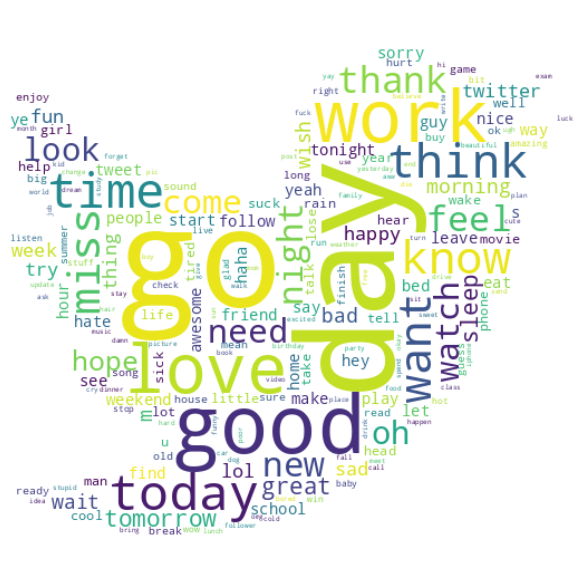

In [91]:
plot_wordcloud(" ".join(all_lemmas), name="wordcloud2")

---
>#### `TODO`  done ✅ | todo ❌ |

#### Sauvegardons la version lemmatisée du jeu de données pour pouvoir essayer leur impact sur nos modèles

In [92]:
data_nlp_steps = pd.DataFrame()
data_nlp_steps['lemmas'] = data_nlp.lemmas
data_nlp_steps['target'] = data_nlp.target
display(data_nlp_steps.head(2), data_nlp_steps.shape)

data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_lemmas.bin')
joblib.dump((data_nlp_steps), data_nlp_path)

,lemmas,target
1180586,"[omg, yes, yes, yes, watch]",1
1471360,"[excuse, wii]",1


(456560, 2)

['/home/valkea/Dev/OpenClassrooms/Projets_AI/P7/data/data_nlp_lemmas.bin']

---
## 4.4 Suppression des mots les plus fréquents <a class="anchor" id="NLP_most_frequents"></a> [⇪](#menu)

In [93]:
lemmas_freq = Counter(all_lemmas)
common_lemmas = lemmas_freq.most_common(100)
print (common_lemmas)

[('go', 34917), ('day', 32583), ('good', 32501), ('get', 27538), ('work', 26194), ('love', 22728), ('like', 21872), ('today', 21436), ('time', 20344), ('think', 18361), ('know', 17680), ('want', 17448), ('miss', 16702), ('thank', 16670), ('feel', 15337), ('night', 13854), ('come', 13324), ('watch', 13130), ('need', 13092), ('new', 12632), ('look', 12326), ('oh', 12141), ('hope', 11568), ('great', 10639), ('tomorrow', 10616), ('sleep', 10589), ('morning', 10391), ('wish', 10297), ('m', 10108), ('bad', 10092), ('wait', 9964), ('sad', 9095), ('twitter', 8952), ('week', 8674), ('fun', 8654), ('try', 8539), ('happy', 8245), ('thing', 8141), ('lol', 8089), ('tonight', 8037), ('friend', 7841), ('sorry', 7832), ('leave', 7482), ('find', 7466), ('nice', 7435), ('haha', 7314), ('way', 7174), ('bed', 6852), ('yeah', 6736), ('start', 6672), ('see', 6498), ('school', 6449), ('people', 6424), ('hour', 6409), ('tweet', 6322), ('hate', 6248), ('weekend', 6065), ('guy', 6024), ('play', 5862), ('home', 

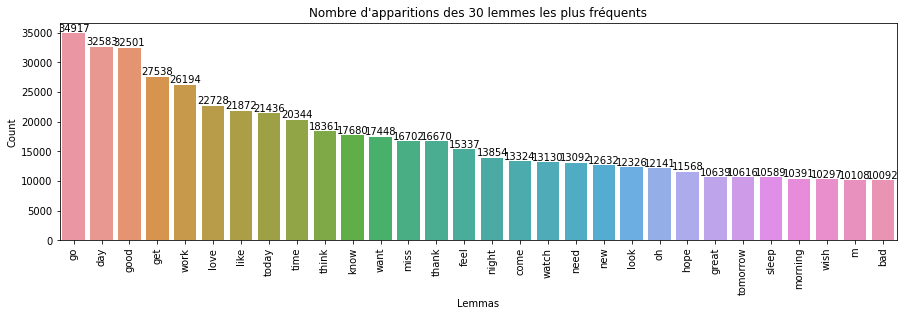

In [94]:
select = pd.DataFrame(common_lemmas[:30], columns=['lemmas','count'])
plot_bars(select, title="Nombre d'apparitions des 30 lemmes les plus fréquents", x='lemmas', y='count', show_values=True, y_label="Count", x_label="Lemmas")

---
## 4.5 Création du Dictionnaire <a class="anchor" id="NLP_dict"></a> [⇪](#menu)

Pour les modèles que nous allons essayer, il nous faut un **Dictionnaire** et un **Corpus**.
- Le Dictionnaire permet d'associer un ID unique à chaque token.
- Le `Corpus - Bag Of Word` contient une liste (un pour chaque document) de *term vectors* qui indiquent la fréquence de chaque mot du *vocabulaire*.
- Le `Corpus - TF-IDF` est une version *normalisée* du précédent pour éviter que des mots sans importance mais fréquents prennent trop d'importance.

In [95]:
from gensim.corpora.dictionary import Dictionary

In [96]:
dictionary = Dictionary(data_nlp['lemmas'])

In [97]:
print(str(dictionary.token2id)[:1000], "... }")

{'omg': 0, 'watch': 1, 'yes': 2, 'excuse': 3, 'wii': 4, 'long': 5, 'pool': 6, 'summer': 7, 'classify': 8, 'condition': 9, 'know': 10, 'medical': 11, 'try': 12, 'tattoo': 13, 'wait': 14, 'burglar': 15, 'guard': 16, 'hand': 17, 'kodo': 18, 'lick': 19, 'live': 20, 'well': 21, 'bad': 22, 'cheek': 23, 'ear': 24, 'head': 25, 'hurt': 26, 'nap': 27, 'sinuse': 28, 'wake': 29, 'help': 30, 'let': 31, 'question': 32, 'welcome': 33, 'cheer': 34, 'come': 35, 'day': 36, 'refreshing': 37, 'see': 38, 'find': 39, 'ipod': 40, 'touch': 41, 'awesome': 42, 'end': 43, 'friend': 44, 'nervous': 45, 'song': 46, 'tease': 47, 'good': 48, 'moood': 49, 'tired': 50, 'bleh': 51, 'buy': 52, 'feel': 53, 'new': 54, 'pair': 55, 'shoe': 56, 'spending': 57, 'sporkiness': 58, 'tomorrow': 59, 'wanna': 60, 'work': 61, 'channel': 62, 'have': 63, 'history': 64, 'spike': 65, 'tv': 66, 'unfortunate': 67, 'd': 68, 'info': 69, 'oh': 70, 'remember': 71, 'thanx': 72, 'expert': 73, 'like': 74, 'retweet': 75, 'thank': 76, 'bed': 77, 'f

In [98]:
len(dictionary)

87805

#### Supprimons les mots les plus fréquents et les moins fréquents
- On supprime les mots qui apparaissent dans moins de 5 documents
- On supprime les mots qui apparaissent dans plus de 50% des documents

In [99]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=None)

In [100]:
len(dictionary)

16919

#### Récupérons la Fréquence de chaque lemme pour afficher à nouveau le WordCloud

In [101]:
dico_df = pd.DataFrame(dictionary.items(), columns=['index', 'key']).set_index('index')

In [102]:
values = [[x[0], x[1]] for x in dictionary.cfs.items()]

In [103]:
count_df = pd.DataFrame(values, columns=['index','count']).set_index('index').sort_values('index')

In [104]:
TF = count_df.merge(dico_df, on='index', how='left').set_index('key')

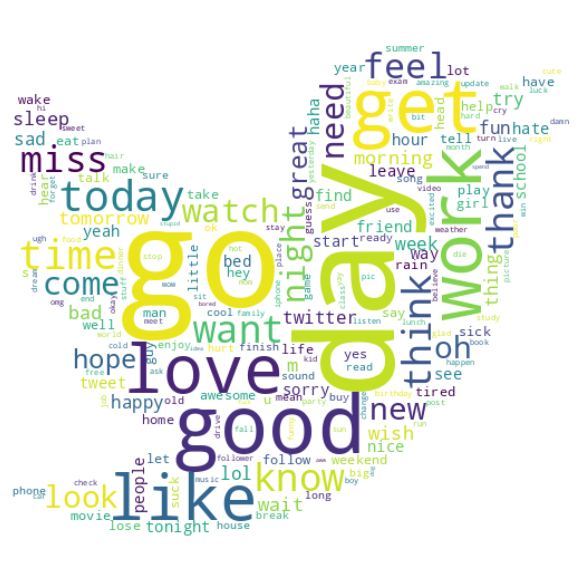

In [105]:
plot_wordcloud(TF.to_dict()['count'], from_frequency=True, name="wordcloud3")

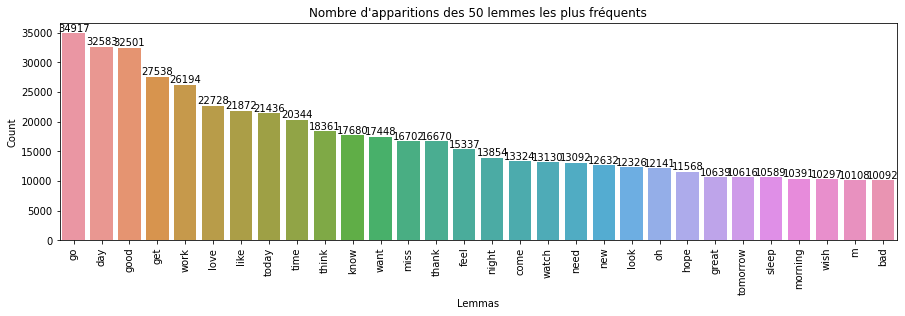

In [106]:
plot_bars(TF.sort_values('count', ascending=False)[:30].T, title="Nombre d'apparitions des 50 lemmes les plus fréquents", show_values=True, y_label="Count", x_label="Lemmas")

---
---
# 5. Sauvegarde du jeu de données de travail <a class="anchor" id="save_dataset"></a> [⇪](#menu)

In [107]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp.csv')
data_nlp.to_csv(data_nlp_path, index=False)

In [108]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp.bin')
joblib.dump((data_nlp[['target','lemmas']]), data_nlp_path)

['/home/valkea/Dev/OpenClassrooms/Projets_AI/P7/data/data_nlp.bin']